# Ejercicio 5 - guía 3

A partir del dataset del ejercicio anterior...

## a)
Ajustar una regresión lineal múltiple de MPG en función de todas las otras variables. Hacer
los gráficos pertinentes para analizar el comportamiento del modelo.

### Desarrollo

Primero parto por cargar el dataset que estuve trabajando el ejercicio pasado:

In [1]:
import pandas as pd
import os

ruta_datos_autos = os.path.join('..', '..','datos', 'processed' ,'auto-mpg-processed.csv')

df_autos = pd.read_csv(ruta_datos_autos)

Ahora veamos cúales son las variables númerícas que tenemos disponibles:

In [2]:
df_autos.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


Entonces a partir de observar los valores que toman las columnas, estoy en condiciones de ajustar un modelo de regresión múltiple:

In [31]:
import numpy as np

variables_predictoras = ['horsepower', 'weight', 'acceleration', 'cylinders', 'displacement', 'model year', 'origin']

X = df_autos[variables_predictoras].values # Convertimos las variables predictoras de Series a ndarrays
Y = df_autos['mpg'].values # Lo mismo con la variable objetivo

# A X le agregamos una columna de unos para el intercepto
X = np.column_stack((np.ones(X.shape[0]), X))

estimar_bethas = lambda X, Y: np.linalg.inv(X.T @ X) @ X.T @ Y

# Hago la estimación
bethas = estimar_bethas(X, Y)

# Imprimo los coeficientes estimados junto con el nombre de las variables
variables_predictoras.insert(0, 'intercept')
for variable, beta in zip(variables_predictoras, bethas):
    print(f'{variable}: {beta}')
variables_predictoras.pop(0) 

intercept: -17.218434622014318
horsepower: -0.016951144227518436
weight: -0.006474043397439885
acceleration: 0.08057583832471515
cylinders: -0.49337631885857164
displacement: 0.019895643742016134
model year: 0.7507726779502399
origin: 1.4261404954230463


'intercept'

Ahora paso a hacer algunos gráficos para analizar el comportamiento del modelo:

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Hago las predicciones
Y_pred = X @ bethas

# Calculo los residuos
residuos = Y - Y_pred

Hago un gráfico de los residuos vs los valores ajustados:

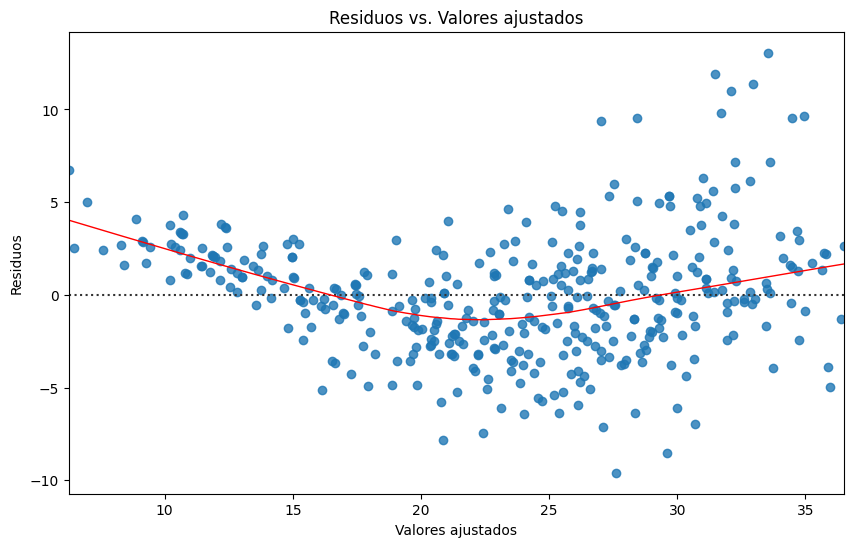

In [26]:
plt.figure(figsize=(10, 6))
sns.residplot(x=Y_pred, y=residuos, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.title('Residuos vs. Valores ajustados')
plt.show()

Hago un histograma de los residuos:

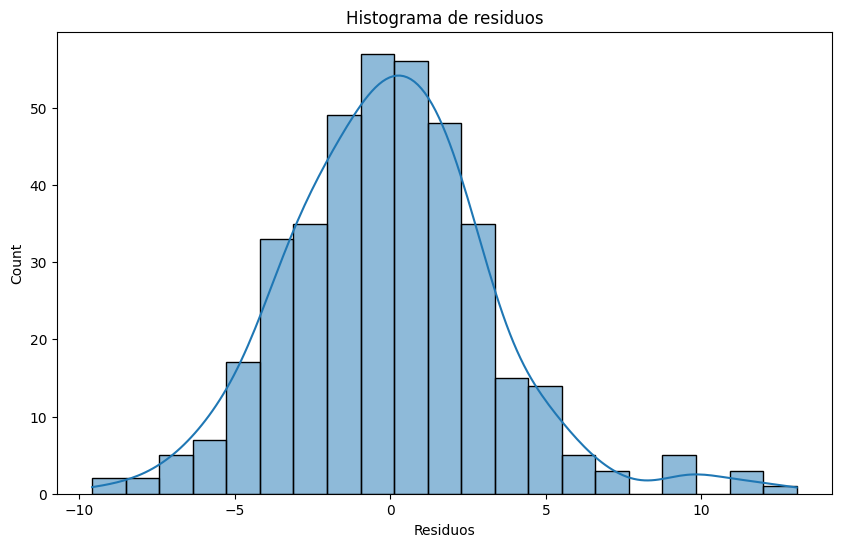

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.xlabel('Residuos')
plt.title('Histograma de residuos')
plt.show()

Finalmente hago un gráfico de los valores observados vs los valores ajustados:

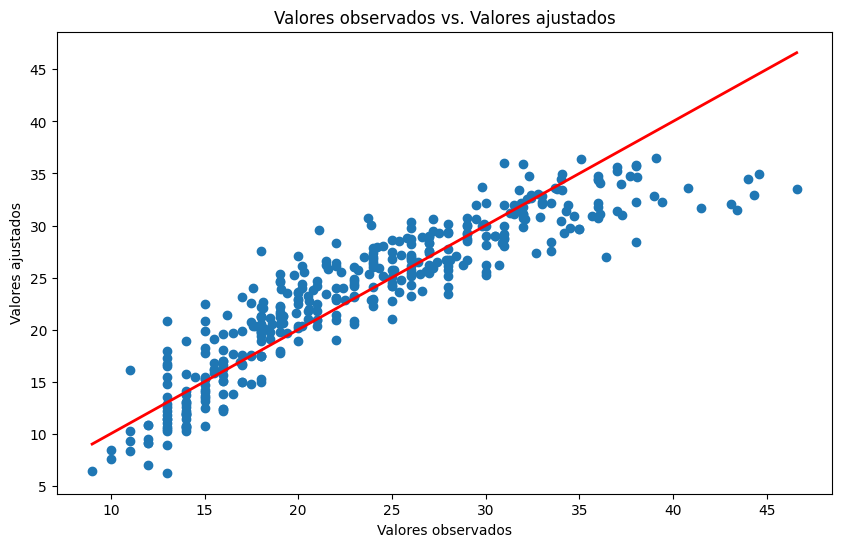

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(Y, Y_pred)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', lw=2)
plt.xlabel('Valores observados')
plt.ylabel('Valores ajustados')
plt.title('Valores observados vs. Valores ajustados')
plt.show()

## b)
Hacer forward selection para seleccionar el mejor modelo de regresión según el estadístico de
Mallow. Este proceso consiste en agregar una variable a la vez al modelo inicial y comparar
el valor del estadístico de Mallow para cada modelo, eligiendo el del valor más bajo.

### Desarrollo

Primero defino algunas funciones que serán útiles para realizar el experimento:

In [29]:
def calcular_sse(X, Y, betas):
    """Calcula la suma de los errores al cuadrado (SSE)."""
    predicciones = X @ betas
    errores = Y - predicciones
    SSE = np.sum(errores ** 2)
    return SSE

def calcular_sigma2(X, Y, betas):
    """Calcula la varianza estimada del modelo completo."""
    n = len(Y)
    SSE = calcular_sse(X, Y, betas)
    sigma2 = SSE / (n - X.shape[1])  # Ajuste de grados de libertad
    return sigma2

def mallows_cp(X_train, Y_train, X_test, Y_test, betas_full):
    """
    Calcula el estadístico de Mallows Cp.
    
    Parámetros:
    X_train: Subconjunto de predictores para entrenar el modelo.
    Y_train: Valores de la variable dependiente del conjunto de entrenamiento.
    X_test: Conjunto de predictores completo.
    Y_test: Valores de la variable dependiente del conjunto completo.
    betas_full: Betas estimadas para el modelo completo.

    Retorna:
    cp: Estadístico Cp de Mallows.
    """
    # Estimo los betas del subconjunto
    betas_subset = estimar_bethas(X_train, Y_train)
    
    # Calculo la suma de los errores cuadráticos (SSE) del modelo con el subconjunto
    SSE_p = calcular_sse(X_train, Y_train, betas_subset)
    
    # Calculo la varianza estimada (sigma^2) usando el modelo completo
    sigma2 = calcular_sigma2(X_test, Y_test, betas_full)
    
    # Tomo la cantidad de predictores del modelo ajustado en el subconjunto, incluyendo el intercepto
    p = X_train.shape[1] 
    
    # Tomo la cantidad de observaciones
    n = len(Y_train)
    
    # Calculo el estadístico Cp
    return (SSE_p / sigma2) + 2 * p - n

Ahora realizo forward selection, apoyándome en un dataframe para ir guardando los resultados:

In [38]:
import pandas as pd
import copy  

# Armo una lista inicialmente sin predictores
lista_predictores_modelo = []

# Construyo un dataframe de pandas donde iré guardando los resultados
resultados = pd.DataFrame(columns=['predictores', 'Cp'])

# Y ahora realizo forward selection
for predictor in variables_predictoras:
    # Agrego el predictor a la lista
    lista_predictores_modelo.append(predictor)
    
    # Estimo los betas del modelo con los predictores actuales
    X_train = df_autos[lista_predictores_modelo].values
    X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
    
    # Calculo el Cp de Mallows
    cp = mallows_cp(X_train, Y, X, Y, bethas)
    
    # Guardo los resultados con una copia profunda de la lista
    nuevo_registro = pd.DataFrame({'predictores': [copy.deepcopy(lista_predictores_modelo)], 'Cp': [cp]})
    resultados = pd.concat([resultados, nuevo_registro], ignore_index=True)

C:\Users\gerar\AppData\Local\Temp\ipykernel_13200\4070731037.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, nuevo_registro], ignore_index=True)


In [39]:
resultados

,predictores,Cp
0,[horsepower],459.603846
1,"[horsepower, weight]",245.585705
2,"[horsepower, weight, acceleration]",247.585248
3,"[horsepower, weight, acceleration, cylinders]",246.752207
4,"[horsepower, weight, acceleration, cylinders, ...",248.752071
5,"[horsepower, weight, acceleration, cylinders, ...",32.291171
6,"[horsepower, weight, acceleration, cylinders, ...",8.000000


## c)
Realizar la regresión con todas las variables, pero con regularización de Ridge y de Lasso.
Dividir el dataset en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%)
para elegir el mejor valor de 𝜆 para cada uno.